In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vegas
from constants import *

In [2]:
from geometry import get_rprime,get_d,get_D,get_cosPsi
from crossSection import get_BDMv,get_BDMp,diffCrossSectionNuDM,get_Ev_cosPhi

In [3]:
def dnv(d,Ev,Lv = Lv,tau = 10):
    """
    Neutrino number density per energy at d
    
    Input
    ------
    Enu: Neutrino energy in MeV
    d: Distance to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s
    tau: duration of the SN explosion
    
    Output
    ------
    Neutrino flux at d: # per Enu per cm**3
    """
    Lv = Lv*erg2MeV*tau
    d = d*kpc2cm
    
    # Fermi dirac distribution
    def _fv(Ev,Tv):
        exponent = Ev/Tv - 3
        return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    luminosity = Lv/(4*np.pi*d**2*light_speed)
    return luminosity*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx):
    """
    DM halo number density at r in MW
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    rr=r/24.42
    return (184/mx)/(rr*(1 + rr)**2)

The term $dE_\nu/dT_\chi$ can be evaluated through the reciprocal of
$$
\frac{dT_\chi}{dE_\nu} = \frac{d}{dE_\nu}\left( E_\nu - \frac{E_\nu m_\chi}{m_\chi + E_\nu(1-\cos\phi)}\right)
$$
where
$$
\cos\phi = \frac{1}{\sqrt{1+\frac{\sin^2\psi}{(E_\nu/p_\chi -\cos\psi)^2}}}.
$$
We solved this with 
$$
\frac{d T_\chi}{dE_\nu}=1+\frac{E_{\nu}m_{\chi}}{[m_{\chi}+E_{\nu}(1-1/\sqrt{\xi})]^{2}}\left[1-\frac{E_{\nu}\sin^{2}\psi}{p_{\chi}(\frac{E_{\nu}}{p_{\chi}}-\cos\psi)^{3}\xi^{3/2}}-\frac{1}{\sqrt{\xi}}\right]-\frac{m_{\chi}}{m_{\chi}+E_{\nu}(1-1/\sqrt{\xi})}
$$
where
$$
\xi = 1+\frac{\sin^2\psi}{(E_\nu/p_\chi -\cos\psi)^2}
$$

In [34]:
def dEvdTx(Ev,Tx,mx,psi):
    """
    Get the dEv/dTx for the given inputs
    """
    px = get_BDMp(Tx,mx)
    xi = 1 + np.sin(psi)**2/(Ev/px - np.cos(psi))**2
    A = Ev*mx/(mx + Ev*(1 - 1/np.sqrt(xi)))**2
    B = 1 - Ev*np.sin(psi)**2/px/(Ev/px - np.cos(psi))**3/xi**1.5 - 1/np.sqrt(xi)
    C = mx/(mx + Ev*(1 - 1/np.sqrt(xi)))
    dTxdEv = 1 + A*B - C
    return 1/dTxdEv


def xemissivity(Tx,mx,mV,r,d,Rstar,psi,Re = 8.5,gV = 1,gD = 1,max_Ev = 100):
    """
    Evaluate the BDM emissivity toward the direction psi at the given boosted point 
    
    Input
    ------
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    r: distance from boosted point to GC for calculating DM number density, kpc
    d: distance from boosted point to the Earth, kpc
    Rstar: distance from SN to the Earth, kpc
    psi: the BDM scattering angle, rad
    Re: distance from GC to Earth, default 8.5 kpc
    gV: DM-neutrino coupling constant, default 1
    gD: DM-DM coupling constant, default 1
    max_Ev: maximum neutrino energy to be searched for, default 100 MeV
    
    Output
    ------
    jx: BDM emissivity at the boosted point, 1/(MeV*cm^3*s*rad)
    """
    # Get the required Ev and cos(phi) to generate BDM with kinetic energy Tx with DM
    # scattering angle psi
    Ev,cosPhi,flag1,_ = get_Ev_cosPhi(Tx,mx,psi,max_Ev = max_Ev)
    Evp,_,flag2,_ = get_Ev_cosPhi(Tx+1e-6,mx,psi,max_Ev = max_Ev)
    # If flag is valid, proceed the calculation. Otherwise, terminates the function 
    if flag1 == 'valid' and flag2 == 'valid':
        # flag is valid
        # Get the differential DM-nu scattering cross section
        diffCrox = diffCrossSectionNuDM(cosPhi,Ev,mx,mV,gV,gD)
        # Get the emissivity jx
        jx = light_speed*diffCrox*nx(r,mx)*dnv(d,Ev,Lv=Lv,tau=10)*(Evp - Ev)/1e-6
        return jx
    else:
        # flag is invalid, unphysical inputs
        return 0
        

In [33]:
get_Ev_cosPhi(5,1e-3,0.1),get_Ev_cosPhi(5-1e-4,1e-3,0.1)

((5.001052503258818, 0.05008413487069898, 'valid', 1),
 (5.000952503256714, 0.05008413696940668, 'valid', 1))

In [30]:
(Evp-Ev)/1e-4

1.0000000210386162

In [22]:
Evp

5.00105350325884

In [31]:
dEvdTx(5,Evp,1e-3,0.1)

1.0021967448378222

In [5]:
def get_BDMflux_theta(t,Tx,mx,mV,Rstar,theta,phi,beta,Re = 8.5,gV = 1,gD = 1,max_Ev = 100):
    # Get BDM velocity
    vx = get_BDMv(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = get_d(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = get_D(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = get_rprime(d,Rstar,Re,theta,phi,beta)
    # Get the BDM scattering angle psi
    psi = np.arccos(get_cosPsi(d,Rstar,theta))
    # Evaluate the xemissivity
    jx = xemissivity(Tx,mx,mV,rprime,d,Rstar,psi,Re,gV,gD,max_Ev)
    # Jacobian
    J = light_speed/((d - Rstar*np.cos(theta))/D + 1/vx)
    # BDM flux
    return J*jx*vx*np.sin(theta)

7.498806606935368

In [37]:
Tx = 5
mx = 1e-3
mV = mx/3
theta_ls = np.logspace(-2,np.log10(np.pi/2),20)
phi_ls = np.linspace(0,2*np.pi,20)
bdmflux = []
integ = vegas.Integrator([[0, np.pi/2]])
i = 1
for t in np.logspace(0,np.log10(10*yr2s),50):
    def f(x):
        theta = x[0]
        return 2*np.pi*get_BDMflux_theta(t,Tx,mx,mV,8.5,theta,0,0)
    result = integ(f,nitn=10,neval=5000)
    bdmflux.append(result.mean)
    print(f'{i} out of 50 jobs are completed!',end='\r')
    i+=1

/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:128: RuntimeWarning: invalid value encountered in double_scalars
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:46: RuntimeWarning: invalid value encountered in double_scalars
  cosPsi = (Rstar**2 - D2 - d**2)/(2*D*d)


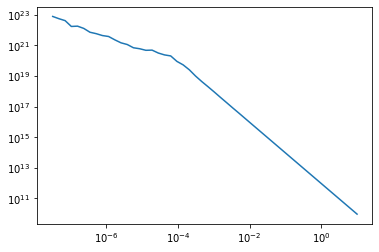

In [41]:
plt.plot(np.logspace(0,np.log10(10*yr2s),50)/yr2s,bdmflux)
plt.xscale('log')
plt.yscale('log')


In [13]:
bdmflux

[7.676400693283983e+22,
 5.814856157114581e+22,
 4.153766269623047e+22,
 1.862343359803063e+22,
 9.588495830568533e+21,
 1.5400010227989158e+22,
 1.190407088925071e+22,
 6.399513140308501e+21,
 5.749735332703918e+21,
 4.3070490010402937e+21,
 3.904842161367486e+21,
 1.9549260648363312e+21,
 1.806526194564945e+21,
 1.337077792305988e+21,
 1.210793396270384e+21,
 6.383430037148246e+20,
 6.100658452497592e+20,
 4.685836521803587e+20,
 4.92088285046379e+20,
 3.308964868607125e+20,
 2.6434572798962732e+20,
 2.5815383583034196e+20,
 1.940753785315387e+20,
 8.67241416050841e+19,
 5.024326409831696e+19,
 2.4826189141328007e+19,
 1.024795515689763e+19,
 4.913312309398212e+18,
 2.5185173218594806e+18,
 1.2583332797935421e+18,
 6.0991293472223e+17,
 2.9659421665310874e+17,
 1.484700216965407e+17,
 7.357898781330315e+16,
 3.636052607603265e+16,
 1.7884892479297224e+16,
 8857251591021189.0,
 4370919251189664.0,
 2159031002005092.0,
 1068426620510047.9,
 527902981622700.6,
 260882826991231.53,
 1288

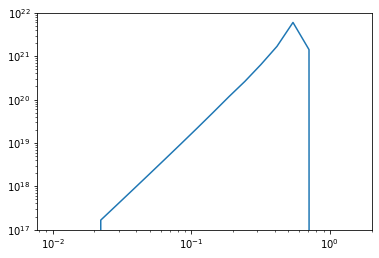

In [49]:
plt.plot(theta_ls,bdmflux)
plt.xscale('log')
plt.yscale('log')

In [44]:
np.log10(np.pi/2)

0.19611987703015263

In [8]:
xemissivity(3,1e-3,1e-3/3,5,5,8.5,8.5,0.1)

(1.2661086379218418e-06, 7.797882545587096e-23)

In [6]:
diffCrossSectionNuDM(np.cos(np.pi),10,0.1,0.033,1,1)

1.9147717830352495e-26

In [12]:
get_Ev_cosPhi(5,5e-3,0.1)

(5.005260413636671, 0.050503352033445734, 'valid', 1)

In [7]:
get_rprime?

Signature: get_rprime(d, Rstar, Re, theta, phi, beta, tolerance=1e-10)
Docstring:
Calculate the distance from boosted point to GC r'

Input
------
d: the l.o.s distance d
Rstar: the distance between Earth and SN
Re: the distance between Earth and the GC
theta: the open-angle in rad
phi: the azimuth angle in rad
beta: the off-center angle in rad

Output
------
r': the distance r'
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [8]:
get_d?

Signature: get_d(t, vx, Rstar, theta)
Docstring:
Calculate the distance l.o.s d

Input
------
t: the arrival time of BDM at Earth relative to the first SN neutrino on the Earth
vx: BDM velocity in the unit of light speed
Rstar: the distance between Earth and SN
theta: the open-angle in rad

Output
------
d: the l.o.s
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [9]:
get_D?

Signature: get_D(d, Rstar, theta, is_square=False)
Docstring:
Calculate the distance between SN and boosted point D

Input
------
d: the l.o.s distance d
Rstar: the distance between Earth and SN
theta: the open-angle in rad
is_square: return the square of such distance, default is False

Output
------
D: the distance D
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [10]:
?get_cosPsi

Signature: get_cosPsi(d, Rstar, theta)
Docstring:
Get the cosine value of scattering angle cos(psi).
If we did it with law of cosine, then for the case of psi > pi/2,
it will always return pi - psi which cannot reflect the pratical
situation

Input
------
d: the l.o.s distance d
Rstar: the distance between Earth and SN
theta: the open-angle in rad

Output
------
psi: scattering angle in rad
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [9]:
get_BDMv?

Signature: get_BDMv(Tx, mx)
Docstring:
The BDM velocity in the unit of light speed

Input
------
Tx: DM kinetic energy
mx: DM mass

Output
------
vx: VDM velocity
File:      ~/GitHub/SNnuBDM2/src/crossSection.py
Type:      function
